## Quantum Walk on a Line

The goal is to create an algorithm for a quantum walk on a line of 16 nodes that are each connected with a single edge.

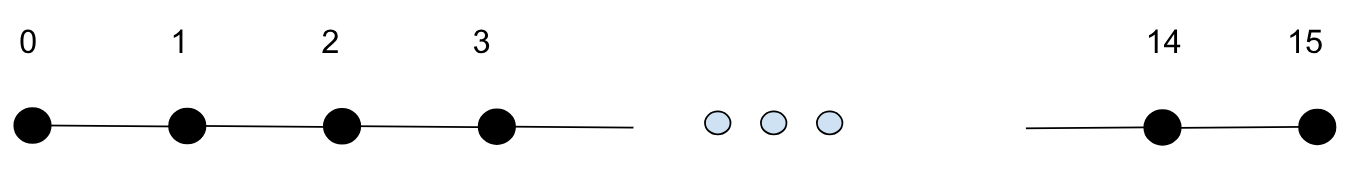

This graph thus contains 16 nodes and 15 edges that connect each adjacent node. Let's begin our program by importing the required dependencies

In [19]:
from classiq import *

### Encoding

We will encode the circuit with n vertices into $log_2(n)$ qubits. Thus, 16 vertices can be encoded into $log_2(16) = 4$ qubits and thus we will also use 4 qubits to encode the adjacent vertices to each vertex.

### Algorithm

The Quantum walk algorithm consists of moving to any adjacent vortex with equal probability. This in the quantum sense entails converting the initial vertex state into a superposition of all the possible future positions (i.e. the adjacent vertices). In order for this operation to also be unitary, we require two sets of registers to actual move the walker to its next location. Each iteration of this algorithm is achieved in two steps, one where we prepare the next destinations and the other where we actually move the walker to its next location. THe first step is done with the help of a grover diffuser operator given by,
$$ C = \sum_{j \in V} \left|j\right>\left<j\right| \otimes (\left|\delta_j\right>\left<\delta_j\right| - I) $$
Which basically includes a phase kickback operation on the adjacent vertices of j controlled on each vertex j in the graph. The second operator is given by a swap (to simulate the movement of the walker),
$$ S = \sum_{j,k \in E} \left|j,k\right>\left<k,j\right|$$

### The C Operator (preparing the future destinations)

To apply this operator, we need to develop the grover diffuser which can be decomposed as follows: $$\left|\delta_j\right>\left<\delta_j\right| - I = U_j (\left|0\right>\left<0\right| - I) U_j^{\dagger}$$
Where the $U_j$ is the unitary that transforms the $\left|0\right>$ state into the vertex adjacent to the vertex j. Hence, This unitary can be applied using inplace_prepare_state function with the equal probabilities given to consecutive qubits around the target qubit. This can then be used with a control operation for each vertex to apply the final C operator to the registers.

In [20]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  # Diffuzer operator (|0><0| - I)
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0] * 16
    # Change the probabilities of adjacent states in the line
    if i == 0:
        prob[i + 1] = 1
    elif i == 15:
        prob[i - 1] = 1
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
        
    print(f'State={i}, prob vec ={prob}')

    # Apply the diffuzer controlled on the given vertex
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
                # Apply U_j and U_j^
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                # Apply diffuzer
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    # Repeat the application for each vertex
    for i in range(2**4):
      C_iteration(i,vertices,adjacent_vertices)


### The S operator (Moving our walker)

We only need to apply the S operator (the bitwise SWAP) if there exists an edge between two given vertices. We can easily develop an oracle to identify whether an edge exists and store the result in an auxilary qubit which is then controlled to apply the swap operation. The edge oracle sets the resulting qubit to 1 when the adjacent vertices are consecutive to the given vertex or the absolute difference between the given vertices is 1. 

In [21]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    # Check whether absolute difference between vertex is one to verify existence of an edge.
  res |= (((vertices - adjacent_vertices) == 1) |  ((adjacent_vertices - vertices) == 1))


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    # Apply the bitwise swap for 2 given qubit registers
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    # resulting qubit
    res = QNum('res')
    # Check whether edge exists
    edge_oracle(res,vertices,adjacent_vertices)
    # Apply SWAP if edge exists (this moves our walker)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))


### Putting it together (final circuit)

To put it all together, we first create a super position over all vertices and initialize the vertex and adjacent vertex quantum registers. Then apply the C and S operators to execute our quantum walk.

In [22]:

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(4,vertices)
  hadamard_transform(vertices)
  allocate(4,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

### Final circuit

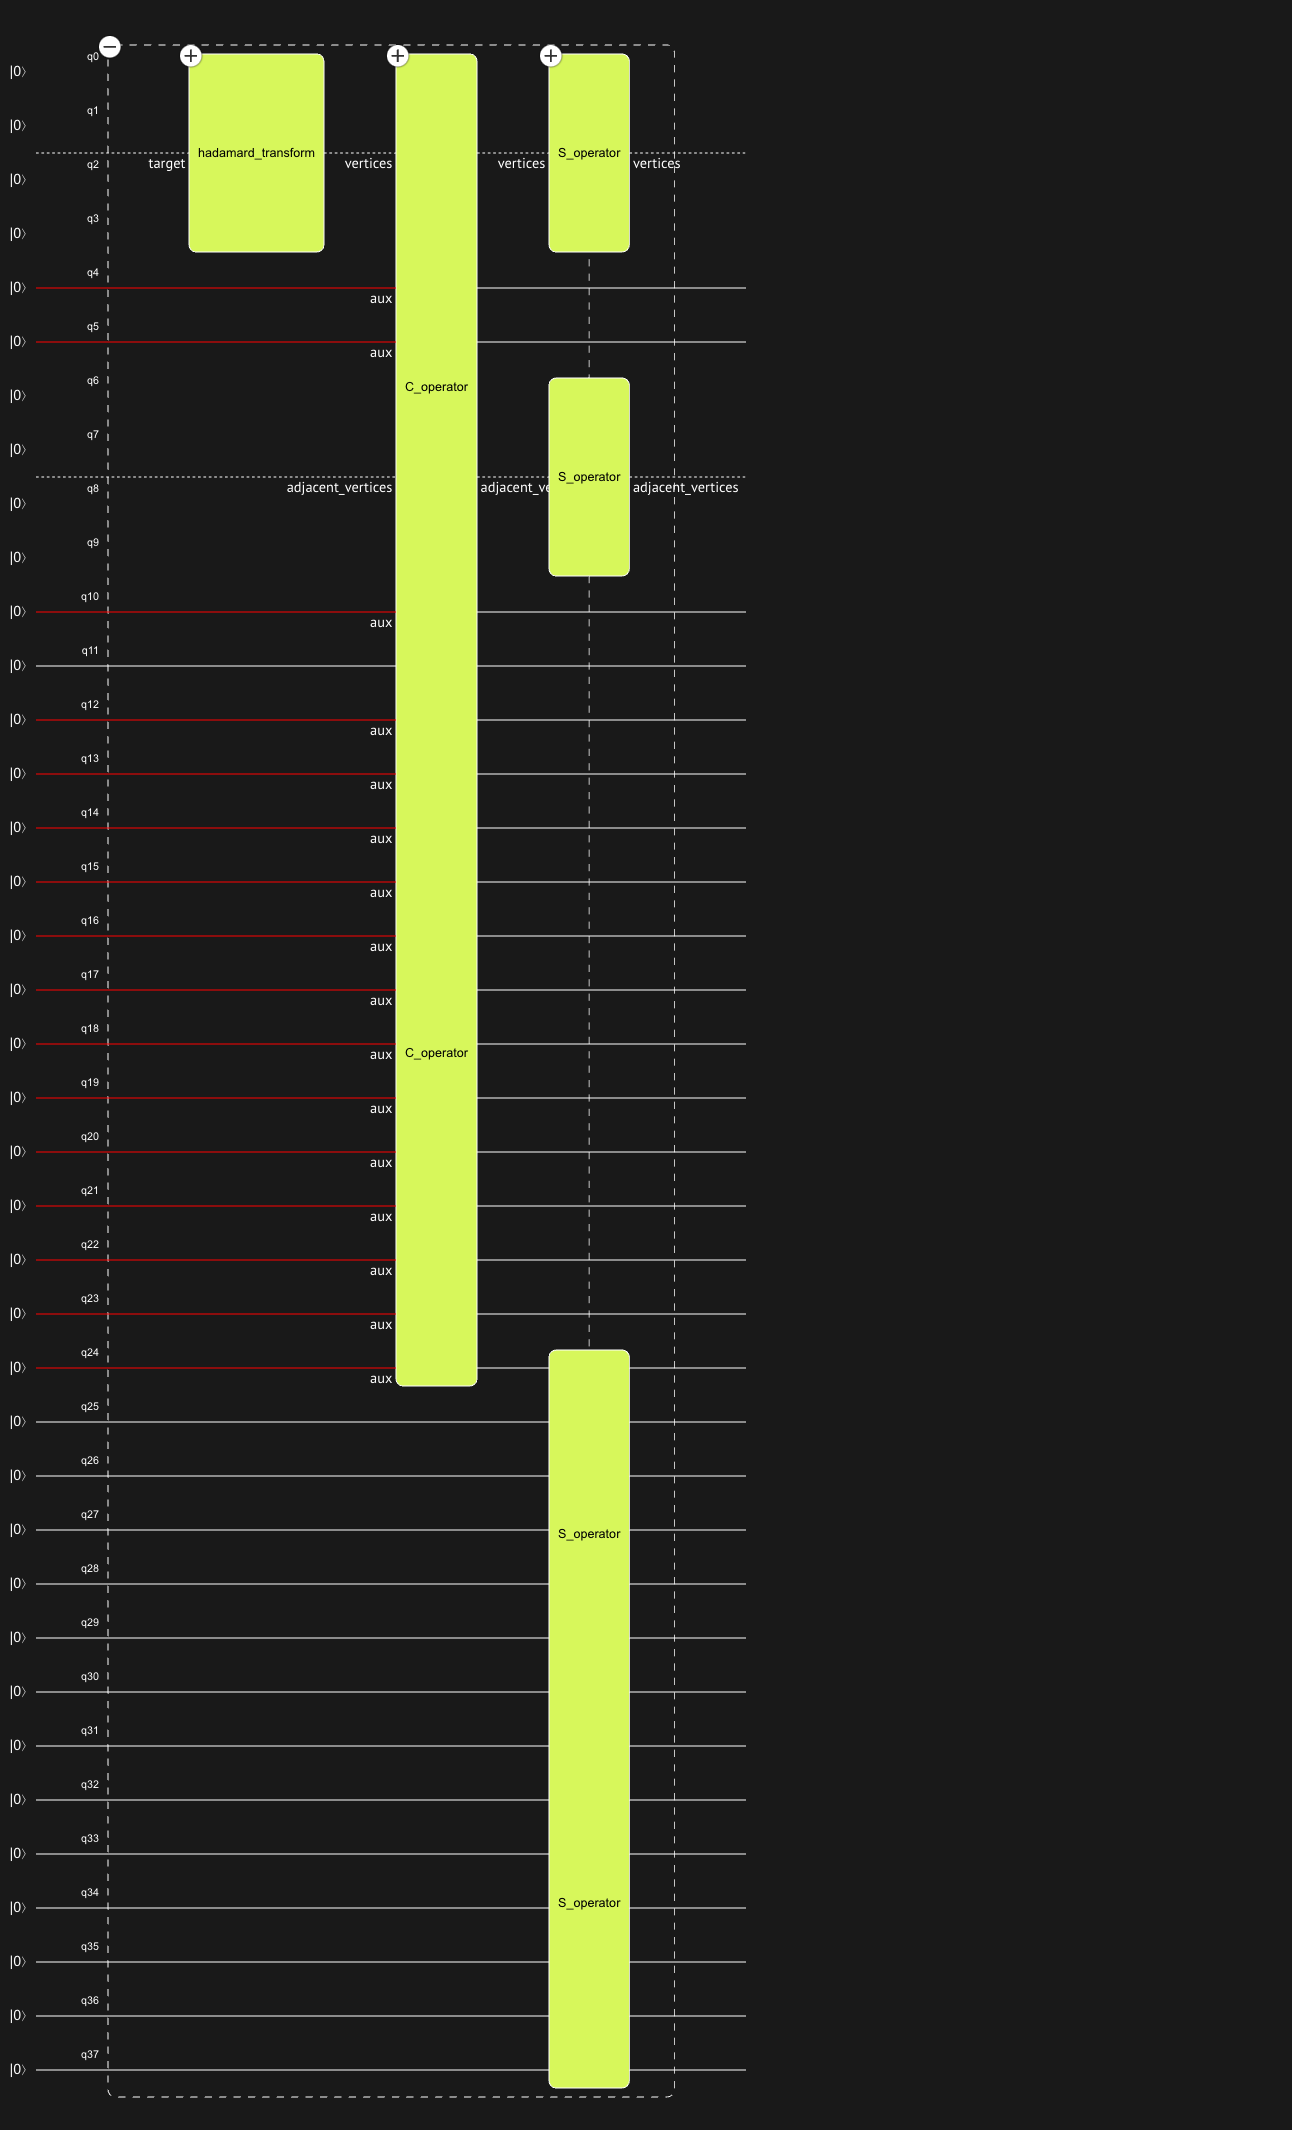